# Introduction
This notebook goes from (preprocessed) EEG data extraction to the fit of the HsMM-MVPA model in multiple conditions

In [1]:
#Loading required libraries, you should have all of these in the .yml 

import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import itertools
import multiprocessing
import os
from mne.decoding import UnsupervisedSpatialFilter
import pyhsmm_mvpa as hsmm

cpus = multiprocessing.cpu_count()


%load_ext autoreload
%autoreload 2


The following cells allow you to restrict the analysis to a subset of the participants. THis will ease the computational load on your machine but will be removed for the final analysis

# Loading EEG data
Then resample and create epochs (i.e. trial where time 0 is the time at which the stimulus appeared) and store in common xarray file (see https://docs.xarray.dev/en/stable/ for more info on that format)

In [2]:
event_id = {'accuracy/left/1':211,'accuracy/left/2':212,'accuracy/left/3':213, #conditions in the experiment
           'accuracy/right/1':221,'accuracy/right/2':222,'accuracy/right/3':223,
            'speed/left/1':111,'speed/left/2':112,'speed/left/3':113, #conditions in the experiment
           'speed/right/1':121,'speed/right/2':122,'speed/right/3':123} # used for segmentation
resp_id = {'r_left':100,'r_right':200}#Response events

save_file = 'epoch_data_condition-wise.nc'
if save_file not in os.listdir():#avoids to loop again if notebook is restarted
    path = 'preprocessed_data/'
    subj_names = [x.split('_')[1].split('.')[0] for x in os.listdir(path) if 'preprocessed' in x]
    print(subj_names)
    subset =  subj_names #alternatively for testing purposes subset = ["S1","S2","S3"]
    epoch_data = hsmm.read_mne_EEG(path,subset,event_id,resp_id,1024)
    epoch_data.to_netcdf(save_file)
    epoch_data = xr.open_dataset(save_file)#For an unknown reason I need to re-read it
else:
    epoch_data = xr.open_dataset(save_file)

In [3]:
epoch_data

<xarray.Dataset>
Dimensions:      (samples: 2148, epochs: 1204, electrodes: 64, participant: 14)
Coordinates:
  * samples      (samples) int32 0 1 2 3 4 5 6 ... 2142 2143 2144 2145 2146 2147
  * epochs       (epochs) int32 0 1 2 3 4 5 6 ... 1198 1199 1200 1201 1202 1203
  * electrodes   (electrodes) object 'Fp1' 'AF7' 'AF3' 'F1' ... 'PO8' 'PO4' 'O2'
  * participant  (participant) object 'S4' 'S16' 'S2' ... 'S14' 'S15' 'S13'
Data variables:
    data         (participant, epochs, electrodes, samples) float64 ...
    event        (participant, epochs) object ...
Attributes:
    sfreq:    1024.0

# Applying HsMM for the speed condition

In [4]:
speed, starts, ends = hsmm.transform_data(epoch_data.where(epoch_data.event.str.contains('speed'),drop=True),\
                           'participant',stack=True)

In [5]:
speed_init = hsmm.hsmm(speed.data.T, starts, ends, sf=epoch_data.sfreq)

In [6]:
max_estimates = speed_init.fit_single(speed_init.max_bumps())

Estimating parameters for 6 bumps model


/home/p308410/projects/pyhsmm-mvpa/pyhsmm_mvpa.py:287: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/p308410/projects/pyhsmm-mvpa/pyhsmm_mvpa.py:293: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Parameters estimated for 6 bumps model


In [7]:
bump_loo_results = [max_estimates]

i = 1
for n_bumps in np.arange(speed_init.max_bumps()-1,0,-1):
    temp_best = bump_loo_results[-i]
    n_bumps_list = np.arange(n_bumps+1)
    possible_bumps = list(itertools.combinations(n_bumps_list, n_bumps))
    possible_flats = list(itertools.combinations(n_bumps_list+1, n_bumps))
    possible_flats = [np.insert(x,0,0) for x in possible_flats]
    with multiprocessing.Pool(processes=cpus) as pool:
        bump_loo_likelihood_temp = pool.starmap(speed_init.fit_single, 
            zip(itertools.repeat(n_bumps),temp_best.magnitudes.values.T[possible_bumps,:],
                temp_best.parameters.values[possible_flats,:],
                itertools.repeat(1),itertools.repeat(True)))
                #repeat(np.tile([1,50], (n_bumps,1))),
                #repeat(np.tile([2,12], (n_bumps,1)))))
    models = xr.concat(bump_loo_likelihood_temp, dim="iteration")
    bump_loo_results.append(models.sel(iteration=[np.where(models.likelihoods ==models.likelihoods.max())[0][0]]))
    i+=1
bests_speed = xr.concat(bump_loo_results, dim="n_bumps")
bests_speed = bests_speed.assign_coords({"n_bumps": np.arange(speed_init.max_bumps(),0,-1)})
bests_speed = bests_speed.squeeze('iteration')
bests_speed

Estimating parameters for 5 bumps model
Estimating parameters for 5 bumps model
Estimating parameters for 5 bumps model
Estimating parameters for 5 bumps model
Estimating parameters for 5 bumps model
Estimating parameters for 5 bumps model
Parameters estimated for 5 bumps model
Parameters estimated for 5 bumps model
Parameters estimated for 5 bumps model
Parameters estimated for 5 bumps model
Parameters estimated for 5 bumps model
Parameters estimated for 5 bumps model
Estimating parameters for 4 bumps model
Estimating parameters for 4 bumps model
Estimating parameters for 4 bumps model
Estimating parameters for 4 bumps model
Estimating parameters for 4 bumps model
Parameters estimated for 4 bumps model
Parameters estimated for 4 bumps model
Parameters estimated for 4 bumps model
Parameters estimated for 4 bumps model
Parameters estimated for 4 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Estimating 

<xarray.Dataset>
Dimensions:      (n_bumps: 6, stage: 7, params: 2, component: 10, bump: 6, samples: 2074, trial: 7603)
Coordinates:
  * n_bumps      (n_bumps) int64 6 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 -1.719e+05 -5.237e+04 ... -5.102e+04
    parameters   (n_bumps, stage, params) float64 2.0 148.1 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 0.01071 -0.008909 ... nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

## Plotting the bump placement from this method

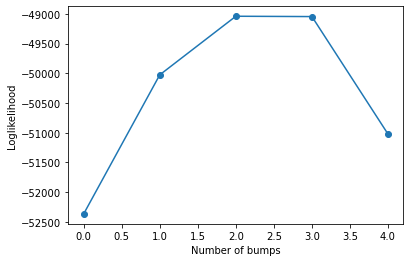

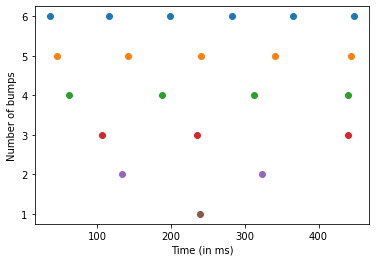

In [8]:
plt.plot(np.arange(speed_init.max_bumps()-1), bests_speed.likelihoods[1:],'o-')
plt.ylabel('Loglikelihood')
plt.xlabel('Number of bumps')
plt.show()
for nbump in np.arange(speed_init.max_bumps(),0,-1):
    times = speed_init.mean_bump_times(bests_speed.sel(n_bumps=nbump))
    plt.plot(times, np.repeat(nbump, len(times)),'o')
plt.xlabel('Time (in ms)')
plt.yticks(np.arange(speed_init.max_bumps())+1)
plt.ylabel('Number of bumps');

In [ ]:
#Looping over possible number of bumps
subjects_idx = data.participant.values
likelihoods_loo = []

for subject in subjects_idx:
    print(f'Subject {subject}')
    
    #Extracting data without left out subject
    stacked_loo = z_scored.sel(participant= subjects_idx[subjects_idx!=subject]).stack(all_samples=["participant",'epochs',"samples"]).dropna(dim="all_samples")
    
    durations_loo = np.unique(epoch_data.sel(participant= subjects_idx[subjects_idx!=subject]).stack(trial=["participant",'epochs']).reset_index(["participant",'epochs']).groupby('trial').count(dim="samples").sel(electrodes="Fpz").data.cumsum().to_numpy())
    starts_loo = np.insert(durations_loo[:-1],0,0)
    ends_loo = durations_loo-1
    
    #Fitting the HsMM using previous estimated parameters as initial parameters
    model_loo = hsmm.hsmm(stacked_loo.to_numpy().T, starts_loo, ends_loo, sf=epoch_data.sfreq)
    with multiprocessing.Pool(processes=cpus) as pool:
        iterative_results_loo = pool.starmap(model_loo.fit_single, 
            zip(np.arange(init.max_bumps(),0,-1),#init.max_bumps to ensure that same number of maxbumps
                bests.magnitudes, bests.parameters, itertools.repeat(1), itertools.repeat(False), itertools.repeat(True)))
    iterative_results_loo = xr.concat(iterative_results_loo, dim="n_bumps")
    
    #Evaluating likelihood for left out subject
    #Extracting data of left out subject
    stacked_left_out = z_scored.sel(participant= subject).stack(all_samples=['epochs',"samples"]).dropna(dim="all_samples")
    
    durations_left_out = np.unique(epoch_data.sel(participant= subject).stack(trial=['epochs']).reset_index(['epochs']).groupby('trial').count(dim="samples").sel(electrodes="Fpz").data.cumsum().to_numpy())
    starts_left_out = np.insert(durations_left_out[:-1],0,0)
    ends_left_out = durations_left_out-1
    
    model_left_out = hsmm.hsmm(stacked_left_out.to_numpy().T, starts_left_out, ends_left_out, sf=epoch_data.sfreq)
    with multiprocessing.Pool(processes=cpus) as pool:
        likelihoods = pool.starmap(model_left_out.calc_EEG_50h, 
            zip(iterative_results_loo.magnitudes,
                iterative_results_loo.parameters,
                np.arange(init.max_bumps(),0,-1),itertools.repeat(True),itertools.repeat(True)))
    likelihoods_loo.append(likelihoods)
    np.save('likelihoods_loo',likelihoods_loo)

# Applying HsMM for the accuracy condition

In [9]:
accuracy, starts, ends = hsmm.transform_data(epoch_data.where(epoch_data.event.str.contains('accuracy'),drop=True),\
                           'participant',stack=True)

In [10]:
accuracy_init = hsmm.hsmm(accuracy.data.T, starts, ends, sf=epoch_data.sfreq)

In [11]:
max_estimates = accuracy_init.fit_single(accuracy_init.max_bumps())

Estimating parameters for 7 bumps model


/home/p308410/projects/pyhsmm-mvpa/pyhsmm_mvpa.py:287: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/p308410/projects/pyhsmm-mvpa/pyhsmm_mvpa.py:293: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Parameters estimated for 7 bumps model


In [12]:
accuracy_init.max_bumps()

7

In [13]:
bump_loo_results = [max_estimates]

i = 1
for n_bumps in np.arange(accuracy_init.max_bumps()-1,0,-1):
    temp_best = bump_loo_results[-i]
    n_bumps_list = np.arange(n_bumps+1)
    possible_bumps = list(itertools.combinations(n_bumps_list, n_bumps))
    possible_flats = list(itertools.combinations(n_bumps_list+1, n_bumps))
    possible_flats = [np.insert(x,0,0) for x in possible_flats]
    with multiprocessing.Pool(processes=cpus) as pool:
        bump_loo_likelihood_temp = pool.starmap(accuracy_init.fit_single, 
            zip(itertools.repeat(n_bumps),temp_best.magnitudes.values.T[possible_bumps,:],
                temp_best.parameters.values[possible_flats,:],
                itertools.repeat(1),itertools.repeat(True)))
                #repeat(np.tile([1,50], (n_bumps,1))),
                #repeat(np.tile([2,12], (n_bumps,1)))))
    models = xr.concat(bump_loo_likelihood_temp, dim="iteration")
    bump_loo_results.append(models.sel(iteration=[np.where(models.likelihoods ==models.likelihoods.max())[0][0]]))
    i+=1
bests_accuracy = xr.concat(bump_loo_results, dim="n_bumps")
bests_accuracy = bests_accuracy.assign_coords({"n_bumps": np.arange(accuracy_init.max_bumps(),0,-1)})
bests_accuracy = bests_accuracy.squeeze('iteration')
bests_accuracy

Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Estimating parameters for 6 bumps model
Parameters estimated for 6 bumps model
Parameters estimated for 6 bumps model
Parameters estimated for 6 bumps model
Parameters estimated for 6 bumps model
Parameters estimated for 6 bumps model
Parameters estimated for 6 bumps model
Parameters estimated for 6 bumps model
Estimating parameters for 5 bumps model
Estimating parameters for 5 bumps model
Estimating parameters for 5 bumps model
Estimating parameters for 5 bumps model
Estimating parameters for 5 bumps model
Estimating parameters for 5 bumps model
Parameters estimated for 5 bumps model
Parameters estimated for 5 bumps model
Parameters estimated for 5 bumps model
Parameters estimated for 5 bumps model
Parameters estimated for 5 bumps model
Parameters e

<xarray.Dataset>
Dimensions:      (n_bumps: 7, stage: 8, params: 2, component: 10, bump: 7, samples: 2148, trial: 7674)
Coordinates:
  * n_bumps      (n_bumps) int64 7 6 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 -5.731e+04 -5.281e+04 ... -5.146e+04
    parameters   (n_bumps, stage, params) float64 2.0 27.67 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 -0.03613 0.03135 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

## Plotting the bump placement from this method

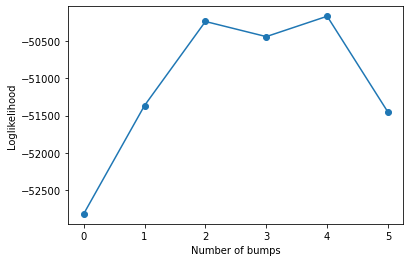

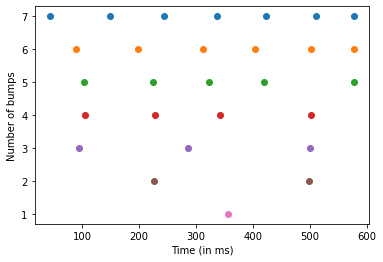

In [14]:
plt.plot(np.arange(accuracy_init.max_bumps()-1), bests_accuracy.likelihoods[1:],'o-')
plt.ylabel('Loglikelihood')
plt.xlabel('Number of bumps')
plt.show()
for nbump in np.arange(accuracy_init.max_bumps(),0,-1):
    times = accuracy_init.mean_bump_times(bests_accuracy.sel(n_bumps=nbump))
    plt.plot(times, np.repeat(nbump, len(times)),'o')
plt.xlabel('Time (in ms)')
plt.yticks(np.arange(accuracy_init.max_bumps())+1)
plt.ylabel('Number of bumps');

# Inspecting best model

In [15]:
bump3_estimates_speed = bests_speed.sel(n_bumps=3)

In [16]:
bump3_estimates_accuracy = bests_accuracy.sel(n_bumps=3)

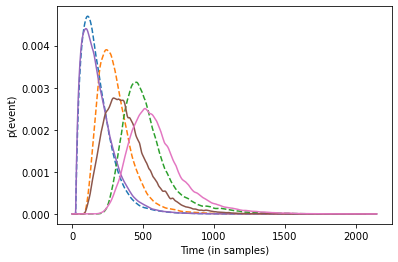

In [17]:
plt.plot(bump3_estimates_speed.eventprobs.mean(dim=['trial']).sel(bump=[0,1,2,3]),'--')
plt.plot(bump3_estimates_accuracy.eventprobs.mean(dim=['trial']).sel(bump=[0,1,2,3]))
plt.ylabel('p(event)')
plt.xlabel('Time (in samples)');

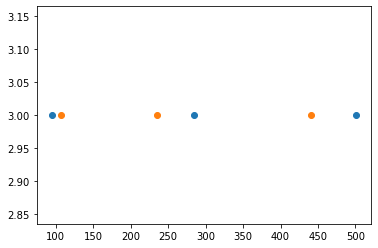

In [18]:
times = accuracy_init.mean_bump_times(bump3_estimates_accuracy)
plt.plot(times, np.repeat(3, len(times)),'o')
times = speed_init.mean_bump_times(bump3_estimates_speed)
plt.plot(times, np.repeat(3, len(times)),'o')